In [59]:
import pandas as pd
import numpy as np

In [60]:
#Sprwadź czy nie dostajesz błędów w którymś z poniższych kodów:
tm = pd.read_excel("Transition_Matrix.xlsx", index_col=0)

#Jeśli będzie błąd to musisz pobrać dane z githuba i pobrać je do folderu w którym jest kod

In [61]:
spread = pd.read_csv('export_History_US_3Y.csv', header=4, index_col = 0)

In [62]:
spread = pd.read_csv('export.csv', header=2, index_col = 0)

## Ryzyko Kredytowe

### Dane których będziemy potrzebować (Nie musisz ich ściągać, bo dane będe podawał na bierząco. Jedynie powinieneś to zrobić kiedy chciałbyś odtworzyć na swojej akcji):
1) Informacje o ratingu (Obligacji/Emitenta) np. https://www.moodys.com/ 
2) Transition Matrix (Macierz przejść) np. https://www.fitchratings.com/research/corporate-finance/2023-transition-default-studies-27-03-2024
3) Informacje na temat recovery rate https://globalcreditdata.org/wp-content/uploads/2023/06/GCD-Banks-RR-Report-2023.pdf
4) Informacje na temat obligacji (Typ długu, kupon, obecna cena rynkowa) https://markets.businessinsider.com/bonds/

Dane: https://www.moodys.com/ 

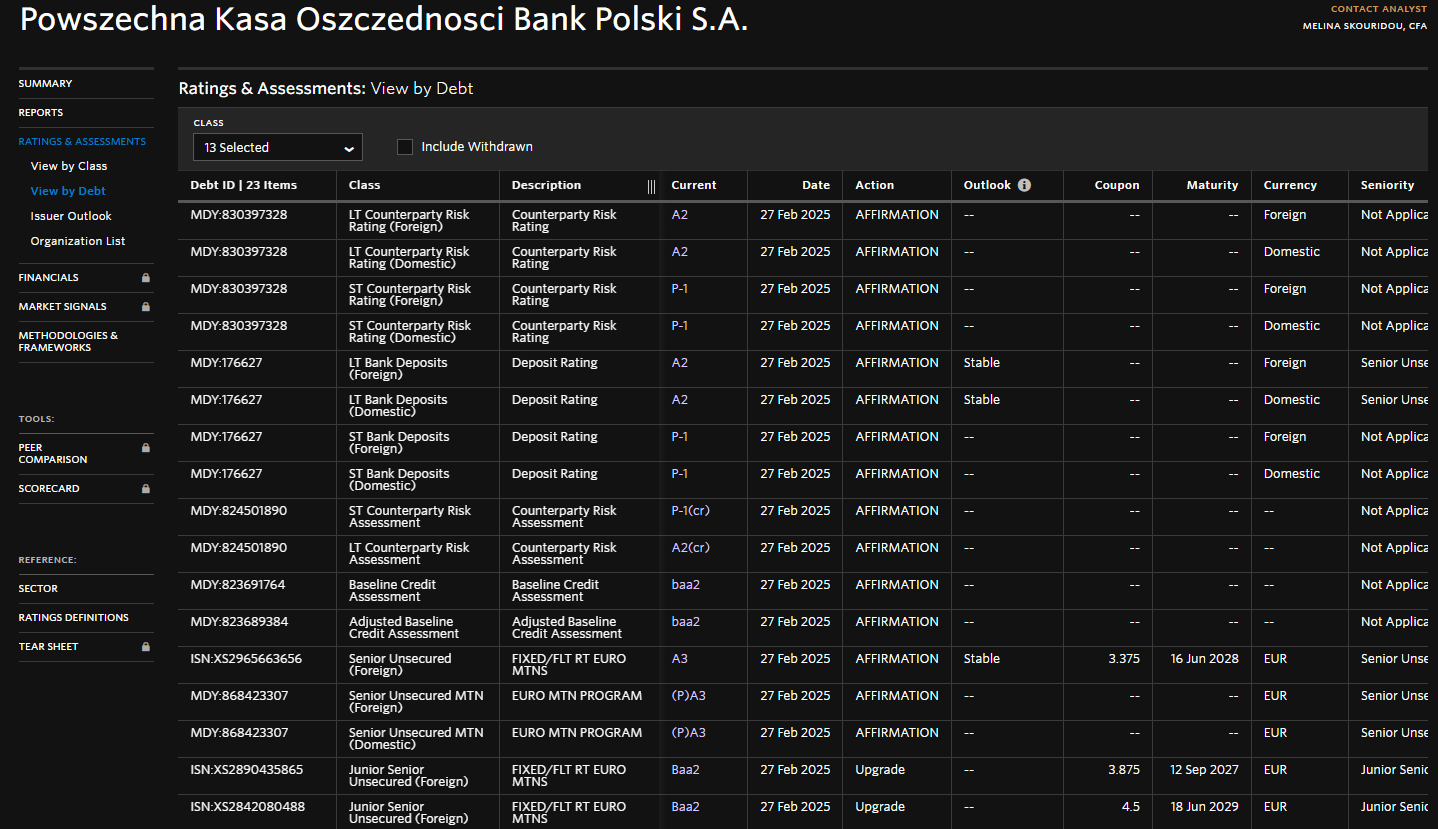

### Aby dowiedzieć się szczegółów możemy skopoiować numer ISN:XS2890435865 i wkleić do wyszukiwarki. Można też przez business insider:
https://markets.businessinsider.com/bonds/powszechna_kopkobk_polskieo-flr_non-prefmtn_2426-27-bond-2027-xs2890435865

### Liczenie Expected Loss dla naszej obligacji PKO: BAA2, Junior Unsecured - (Dla nas dług podporządkowany)

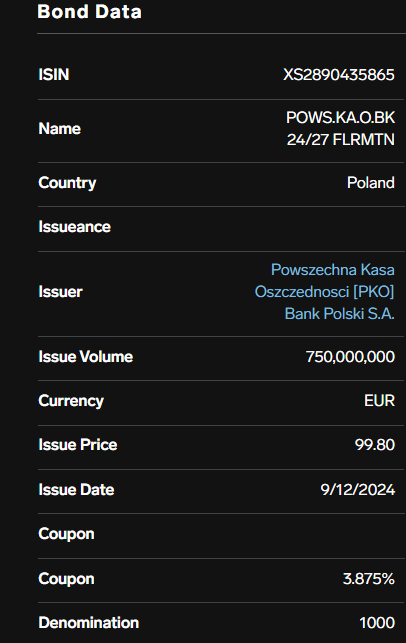 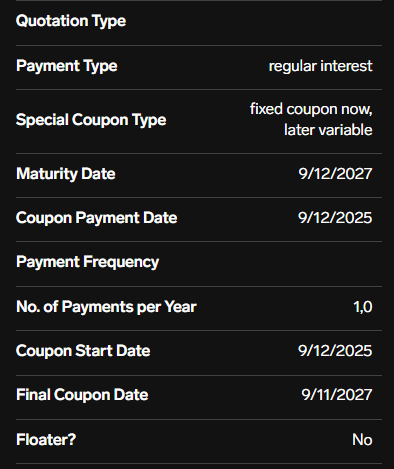 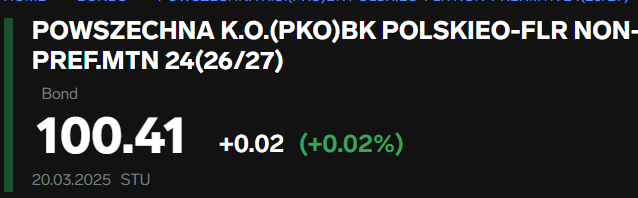

In [63]:
# Linki: https://www.fitchratings.com/research/corporate-finance/2023-transition-default-studies-27-03-2024 - raport fitch aby zdobyć dane dla macierzy przejścia dla różnych przypadków - uwaga nazwy mogą sie różnić (ale z poprzednich wykładów możecie je porównać ze sobą)
#  https://pages.stern.nyu.edu/~eelton/working_papers/corp%20bonds/all%20tables%20and%20figures%201.pdf - Dane użyte w tym przykładzie (MOODY)
tm = pd.read_excel("Transition_Matrix.xlsx", index_col=0)

In [64]:
#Funkcja przekształceń macierzy

def transition_matrix_n_steps(tm_df, n):
    # Konwersja do numpy array
    tm_array = tm_df.to_numpy()
    
    # Obliczenie potęgi macierzy
    tm_n_array = np.linalg.matrix_power(tm_array, n)
    
    # Konwersja z powrotem do DataFrame z zachowaniem indeksów i kolumn
    tm_n_df = pd.DataFrame(tm_n_array, index=tm_df.index, columns=tm_df.columns)
    
    return tm_n_df

In [65]:
#Podgląd macierzy dla n lat
transition_matrix_n_steps(tm, 3) # Nasza obligacja ma +2.7 lata, nasza obliacja ma rating Baa

,Aaa,Aa,A,Baa,Ba,B,Caa,Default
Aaa,0.778401,0.186517,0.032470,0.001943,0.000593,0.000069,0.000002,0.000005
Aa,0.028686,0.767455,0.178133,0.017960,0.006659,0.000919,0.000043,0.000145
A,0.003366,0.064614,0.771114,0.129697,0.022602,0.007187,0.000340,0.001080
Baa,0.000228,0.008897,0.130482,0.695033,0.125521,0.028709,0.002970,0.008158
Ba,0.000050,0.003381,0.017521,0.114454,0.635338,0.156280,0.011400,0.061559
B,0.000038,0.002986,0.004304,0.020120,0.127989,0.569394,0.037500,0.237468
Caa,0.000139,0.008941,0.010817,0.020634,0.053995,0.104685,0.314702,0.486077
Default,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


Recovery rates: https://globalcreditdata.org/wp-content/uploads/2023/06/GCD-Banks-RR-Report-2023.pdf - dla typów długów, regionów 

$$
EL = PD \times LGD \times EAD = PD \times (1 - RR) \times EAD
$$

Gdzie:

- EL– Expected Loss (oczekiwana strata)
- PD – Probability of Default (prawdopodobieństwo niewypłacalności)
- LGD – Loss Given Default (strata w przypadku niewypłacalności)
- EAD – Exposure at Default (ekspozycja na ryzyko w momencie niewypłacalności)
- RR – Recovery Rate (stopa odzysku)



Dla naszego przypadku: PD =  (Z tabeli), Recovery Rate = 0.58 (Z raportu), EAD = To ile zainwestujemy pieniędzy.

In [66]:
# Wyliczenia 
PD = 0.008158
RR = 0.58
EAD = 10000 #(1000 * 10)

# Time to Peak 1.1 - 

EL = PD*(1-RR)*EAD

EL #Premia za ryzyko

34.263600000000004

$$
HPR = \frac{P_{\text{konc}} - P_{\text{pocz}} + D}{P_{\text{pocz}}}
$$

Gdzie:

-  P_konc – cena końcowa instrumentu,
-  P_pocz – cena początkowa instrumentu,
-  D – dochody w trakcie trzymania aktywa (np. dywidendy, kupony).



In [67]:
#Zysk jaki będziemy mieli z obligacji jeśli będziemy ją trzymać do daty wykupu przy założeniu że nie wystąpi niewykonanie.
CN = 1000 # Cena nominalna 
CP = 0.0385 #Kupon
LO = 10 # Liczba obligacji
IK = 2.72 #Ilość kuponów które dostaniemy. Pamiętajcie, że przez to że nie kupujemy równo 3 lata przed datą wykupu to finalnie nie otrzymamy kuponu za cały okres
CENA_P = 101.73
CENA_K = 100

# Obliczenie wartości kuponów, które otrzymamy
kupony = CN * CP * IK * LO

# Obliczenie wartości końcowej obligacji
wartosc_koncowa = (CENA_K / 100) * CN * LO

# Obliczenie wartości początkowej obligacji (cena zakupu)
wartosc_poczatkowa = (CENA_P / 100) * CN * LO

# Obliczenie nominalnego zysku HPR (Holding Period Return)
zysk_nominalny = (wartosc_koncowa + kupony) - wartosc_poczatkowa

# Wyświetlenie wyniku
zysk_nominalny

874.2000000000007

In [68]:
# YTM dla tej obligacji wynosi 3.35  - Dane można obliczyć samemu z kalkulatora obligacji/excelu lub znaleźć na jakiejś ze stron. 
print("YTM",3.35)
#Procentowy roczny zysk wynosi
print("Rozcny zysk % nominalnie:", round((zysk_nominalny)/wartosc_poczatkowa/IK,3)*100)

# W przybliżeniu możemy traktować ytm jako zysk nominalny (jednak pamiętajmy że YTM zakłada że będziemy reinwestowali kupony)

YTM 3.35
Rozcny zysk % nominalnie: 3.2


In [69]:
# Dla porównania YTM niemieckiej obligacji skarbowej DE0001102440 (AAA) to ok 2.160 YTM. Czyli inwestorzy oczekują premi za ryzyko na poziomie:
Premia = 3.35-2.160
Premia # To jest premia roczna

1.19

In [70]:
# Możemy to też przerzucić na nominalną wartość ryzyka. 
Premia/100*10000 #Rocznie

118.99999999999999

Kolejnym prostym sposobem na obliczenie ryzyka kredytowego już dla konkretnej spółki jest Altman Score. Dodatkowo możecie także poprosić swoje modele językowe o analizę.

## Ryzyko Płynności

In [71]:
#pip install plotly
#pip install -U nbformat

In [72]:
#Załóżmy że chcemy wybrać jedną ze następujących spółek
tickers = ["WTN.WA", "ICD.WA", "MND.WA", "CWA.WA", "WIS.WA", "ETL.WA", "SHG.WA", "TBL.WA"]

In [73]:
#Pobranie danych z yfinance
import yfinance as yf
data = yf.download(tickers, period='5y')

[*********************100%***********************]  8 of 8 completed


In [74]:
#Resampling - dzięki temu transformujemy dane z jednego okresu do drugiego
wolumen = data.Volume.resample('1Y').mean()

C:\Users\tomek\AppData\Local\Temp\ipykernel_27312\1612450984.py:2: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



In [75]:
#Wykres interaktywny dla 
import plotly.express as px
fig = px.bar(data.Volume.resample('1YE').mean(), title="Średni wolumen w interwałach jednorocznych")
fig.update_layout(width=1000, height=800, barmode='group')
fig.show()

In [76]:
#Dane dla PEO.WA
Peo = yf.download(['PEO.WA'], start="2020-01-01")['Volume']

[*********************100%***********************]  1 of 1 completed


In [77]:
#Wykres dla PEO.WA
px.bar(Peo.resample("1Y").mean())

C:\Users\tomek\AppData\Local\Temp\ipykernel_27312\1655207422.py:2: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



<Axes: xlabel='Date'>

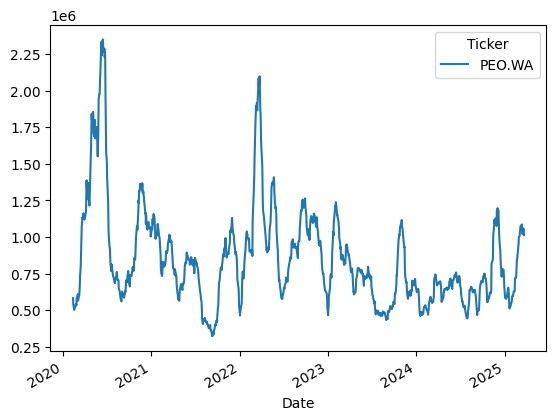

In [78]:
#Rolling window - czyli w jaki sposób możemy liczyć jakiś parametr zmieniający się wczasie dla danego okresu
Peo[Peo.index > "2020.01.01"].rolling(window = "30D").mean()[30:].plot()

<Axes: xlabel='Date'>

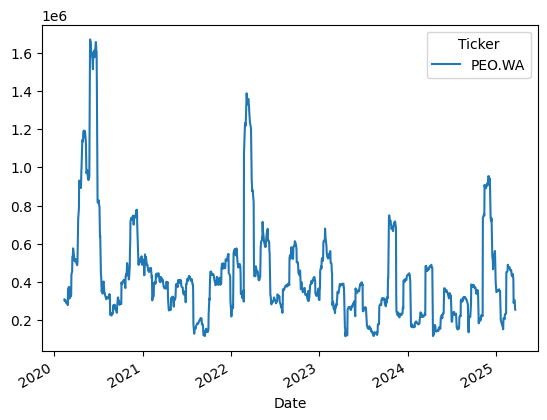

In [79]:
#Dla odchylenia
Peo[Peo.index > "2020.01.01"].rolling(window = "30D").std()[30:].plot()

In [80]:
#Resamplowanie - czyli przkeształcanie okresów i ich wartości w sumy/średnie dla innych okresów
Peo_month = Peo.resample("M").mean()

C:\Users\tomek\AppData\Local\Temp\ipykernel_27312\807632191.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [81]:
#Tabela przestawna
Peo_month.pivot_table(index=Peo_month.index.month, columns=Peo_month.index.year, values="PEO.WA", aggfunc="sum")

Date,2020,2021,2022,2023,2024,2025
Date,,,,,,
1,6.174491e+05,1.076039e+06,1.038728e+06,1.191995e+06,5.003050e+05,5.942687e+05
2,5.775526e+05,8.037109e+05,1.271026e+06,8.444896e+05,5.775639e+05,1.008282e+06
3,1.119533e+06,8.529062e+05,1.696830e+06,8.547705e+05,6.860793e+05,9.786896e+05
4,1.838938e+06,6.446578e+05,9.318982e+05,7.242313e+05,6.481905e+05,NaN
5,1.915721e+06,8.747728e+05,1.204163e+06,7.330014e+05,7.058696e+05,NaN
6,1.551491e+06,8.383257e+05,6.100211e+05,6.581981e+05,6.745100e+05,NaN
7,7.226067e+05,4.507927e+05,8.374226e+05,4.704291e+05,4.552057e+05,NaN
8,5.618974e+05,3.909683e+05,9.313522e+05,4.575064e+05,6.410445e+05,NaN
9,7.388598e+05,4.223427e+05,1.208998e+06,5.416804e+05,6.974608e+05,NaN


In [82]:
#Interaktywny wykres dla różnych miesięcy z wykorzystaniem tabeli przestawnej
px.line(Peo_month.pivot_table(index=Peo_month.index.month, columns=Peo_month.index.year, values="PEO.WA", aggfunc="sum"))

## Spready

$$
\text{Relative Spread}{(\%)} = \left( \frac{\text{Ask} - \text{Bid}}{\left( \text{Ask} + \text{Bid} \right) / 2} \right) \times 100
$$


In [83]:
#Pobranie danych z reutersa - excel
spread = pd.read_csv('export.csv', header=2, index_col = 0)
spread = spread.iloc[::-1]
spread['spread'] = ((spread['Ask']-spread['Bid'])/(spread['Bid']+spread['Ask'])/2)*100

<Axes: >

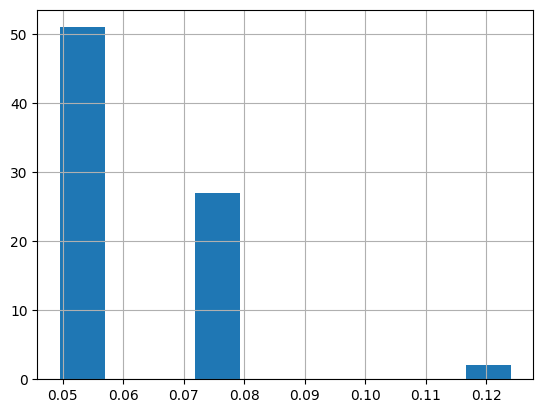

In [84]:
#Wyświetlanie histogramu
spread['spread'].tail(80).hist()

<Axes: xlabel='Date'>

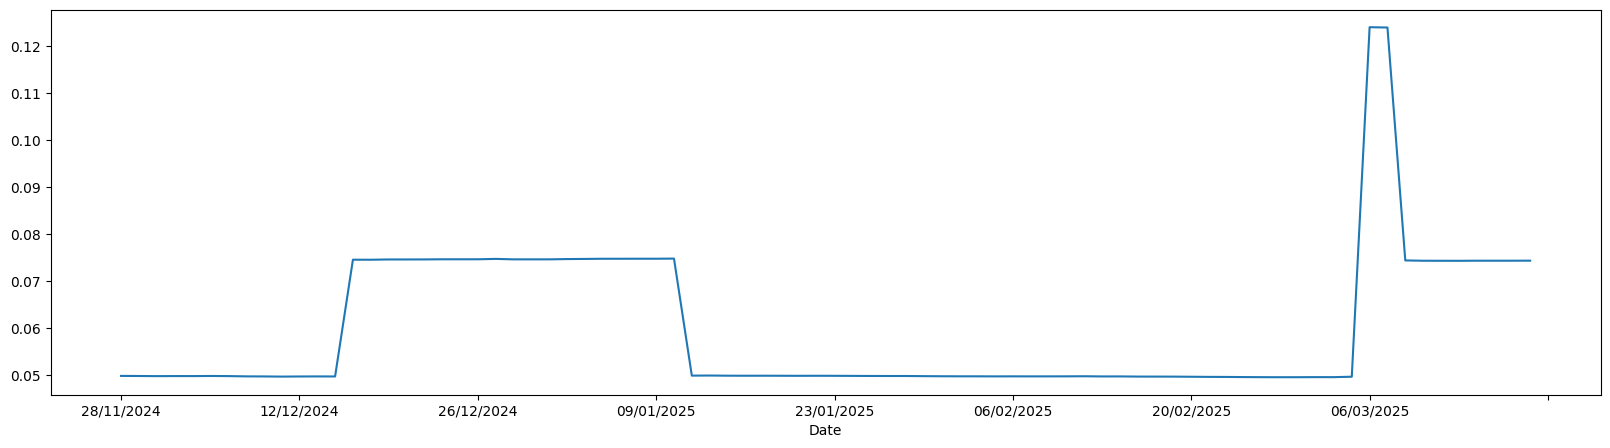

In [85]:
spread['spread'].tail(80).plot(figsize=(20,5))

In [86]:
#Porównanie danych dla Obligacji skarbowych USA 3 letnich z Reutersa
spread = pd.read_csv('export_History_US_3Y.csv', header=4, index_col = 0)
spread = spread.iloc[::-1]
spread['spread'] = ((spread['Ask']-spread['Bid'])/(spread['Bid']+spread['Ask'])/2)*100


<Axes: >

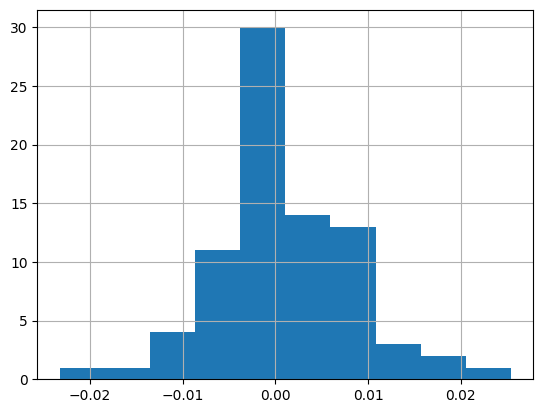

In [87]:
#Wyświetlenie histogramu spreadów
spread['spread'].tail(80).hist()

<Axes: xlabel='Date'>

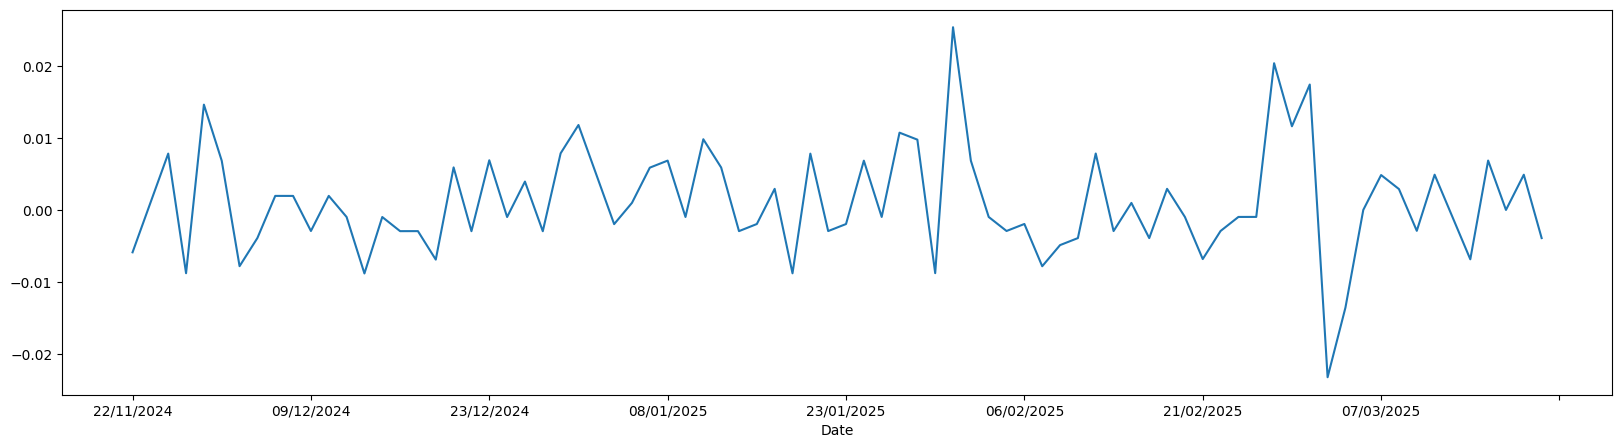

In [88]:
spread['spread'].tail(80).plot(figsize=(20,5))

## Ryzyko Rynkowe

In [89]:
#Określenie tickera
portfel = ['AAPL', 'NVDA', 'GOOGL']

In [90]:
# Pobranie portfela
portfel_series = yf.download(portfel)

[*********************100%***********************]  3 of 3 completed


In [91]:
#Podgląd naszego portfela
portfel_series

Price            Close                                High              \
Ticker            AAPL       GOOGL        NVDA        AAPL       GOOGL   
Date                                                                     
1980-12-12    0.098726         NaN         NaN    0.099155         NaN   
1980-12-15    0.093575         NaN         NaN    0.094005         NaN   
1980-12-16    0.086707         NaN         NaN    0.087136         NaN   
1980-12-17    0.088853         NaN         NaN    0.089282         NaN   
1980-12-18    0.091429         NaN         NaN    0.091858         NaN   
...                ...         ...         ...         ...         ...   
2025-03-17  214.000000  164.289993  119.529999  215.220001  166.300003   
2025-03-18  212.690002  160.669998  115.430000  215.149994  164.250000   
2025-03-19  215.240005  163.889999  117.519997  218.759995  165.869995   
2025-03-20  214.100006  162.800003  118.529999  217.490005  164.889999   
2025-03-21  214.110001         NaN         NaN  214.410004         NaN   

Price                          Low                                Open  \
Ticker            NVDA        AAPL       GOOGL        NVDA        AAPL   
Date                                                                     
1980-12-12         NaN    0.098726         NaN         NaN    0.098726   
1980-12-15         NaN    0.093575         NaN         NaN    0.094005   
1980-12-16         NaN    0.086707         NaN         NaN    0.087136   
1980-12-17         NaN    0.088853         NaN         NaN    0.088853   
1980-12-18         NaN    0.091429         NaN         NaN    0.091429   
...                ...         ...         ...         ...         ...   
2025-03-17  122.889999  209.970001  163.669998  118.029999  213.309998   
2025-03-18  119.019997  211.490005  156.720001  114.540001  214.160004   
2025-03-19  120.449997  213.750000  161.000000  115.680000  214.220001   
2025-03-20  120.199997  212.220001  160.960007  116.470001  213.990005   
2025-03-21         NaN  211.470001         NaN         NaN  211.514999   

Price                                  Volume                           
Ticker           GOOGL        NVDA       AAPL       GOOGL         NVDA  
Date                                                                    
1980-12-12         NaN         NaN  469033600         NaN          NaN  
1980-12-15         NaN         NaN  175884800         NaN          NaN  
1980-12-16         NaN         NaN  105728000         NaN          NaN  
1980-12-17         NaN         NaN   86441600         NaN          NaN  
1980-12-18         NaN         NaN   73449600         NaN          NaN  
...                ...         ...        ...         ...          ...  
2025-03-17  165.029999  122.739998   48073400  31184300.0  255501500.0  
2025-03-18  163.679993  118.000000   42432400  42074800.0  299686900.0  
2025-03-19  161.759995  117.269997   54385400  34275600.0  273426200.0  
2025-03-20  161.570007  116.550003   48799300  28104400.0  248250400.0  
2025-03-21         NaN         NaN   18682474         NaN          NaN  

[11159 rows x 15 columns]

In [92]:
#Pozbywanie się pustych wyrażeń
portfel_series = portfel_series.Close.dropna()

In [93]:
#Wyciąganie danych dla danego przedziału
portfel_series = portfel_series[portfel_series.index > '2020-01-01']

In [94]:
#Logarytmiczne zwroty
portfel_series_log = np.log(portfel_series/portfel_series.shift(1))

In [95]:
#Nasze logarytmiczne zwroty
portfel_series_log

Ticker,AAPL,GOOGL,NVDA
Date,,,
2020-01-02,NaN,NaN,NaN
2020-01-03,-0.009769,-0.005245,-0.016136
2020-01-06,0.007937,0.026305,0.004185
2020-01-07,-0.004714,-0.001933,0.012034
2020-01-08,0.015958,0.007092,0.001874
...,...,...,...
2025-03-14,0.018007,0.016634,0.051350
2025-03-17,0.002386,-0.007278,-0.017745
2025-03-18,-0.006140,-0.022281,-0.034903


### Odchylenie standardowe (sample standard deviation)
$$
s = \sqrt{\frac{1}{n - 1} \sum_{i=1}^{n} (x_i - \bar{x})^2}
$$

Gdzie:  
- x_i – pojedyncza obserwacja  
- x_bar – średnia arytmetyczna  
- n – liczba obserwacji  
- s – odchylenie standardowe próby

In [96]:
#Obliczanie odchylenia standardowego
portfel_series_log.std()*np.sqrt(250)

Ticker
AAPL     0.314472
GOOGL    0.323925
NVDA     0.541320
dtype: float64

### Średnia arytmetyczna
$$
\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

Gdzie:  
- x_i – pojedyncza obserwacja  
- n – liczba obserwacji  
- bar{x} – średnia arytmetyczna

In [97]:
#Obliczanie średniej
portfel_series_log.mean()*250

Ticker
AAPL     0.206084
GOOGL    0.166302
NVDA     0.570240
dtype: float64

### Semideviation (semistandard deviation)
$$
\text{SemiDev} = \sqrt{\frac{1}{n - 1} \sum_{i=1}^{n} \left( \min(0,\ x_i - \mu) \right)^2}
$$

Gdzie:  
- x_i – zwrot w okresie  
- mu – średnia zwrotów 
- n – liczba obserwacji  
- Uwaga: uwzględniane są tylko zwroty **poniżej średniej** 



In [98]:
#pip install riskfolio-lib
#Semideviation z riskfolio
import riskfolio
# https://riskfolio-lib.readthedocs.io/en/latest/risk.html dokumentacja razem ze wzorami

riskfolio.RiskFunctions.SemiDeviation(portfel_series_log.iloc[:,1].dropna())

0.014893295300617065

### Maximum Drawdown (MDD)
$$
MDD(X) = \max_{j \in (0,N)} \left[ \max_{n \in (0,j)} \left( \sum_{i=0}^{n} X_i \right) - \sum_{i=0}^{j} X_i \right]
$$

Gdzie:  
- X_i – zwroty w kolejnych okresach \( i \)  
- N  – całkowita liczba okresów (np. dni, miesięcy)  
- j – punkt w czasie, w którym obserwujemy spadek  
- t  – wcześniejszy punkt w czasie, w którym osiągnięto maksymalną wartość kapitału

In [99]:
#Maximum drawdown z riskfolio dla zwrotów 
riskfolio.RiskFunctions.MDD_Abs(portfel_series_log.iloc[:,1].dropna())

0.5855502142029982

### Wzór na betę
$$
\beta = \frac{\text{Cov}(R_i, R_m)}{\text{Var}(R_m)}
$$

Gdzie:  
- R_i – zwroty instrumentu (np. spółki)  
- R_m – zwroty rynku (benchmarku)  
- text{Cov}(R_i, R_m) – kowariancja zwrotów instrumentu i rynku  
- text{Var}(R_m)– wariancja zwrotów rynku

In [100]:
# Beta obliczona samodzielnie

# Pobierz dane do 31 marca 2025, wstecz o 90 dni kalendarzowych by mieć 60 sesji
dane = yf.download(["GOOGL", "^GSPC"], start="2024-12-20", end="2025-04-01")

# Licz zwroty dzienne
zwroty = dane['Close'].pct_change().dropna()

# Użyj ostatnich 60 sesji
zwroty_60 = zwroty.tail(60)

# Oblicz beta
beta = zwroty_60["GOOGL"].cov(zwroty_60["^GSPC"]) / zwroty_60["^GSPC"].var()
beta


[*********************100%***********************]  2 of 2 completed


np.float64(1.1995084610434477)

In [101]:
#Beta pobrana z yfinance
yf.Ticker('GOOGL').info['beta']

1.025

### Wskaźniki

### Sharpe Ratio
$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

Gdzie:  
- R_p – średnia stopa zwrotu portfela  
- R_f – stopa wolna od ryzyka  
- sigma_p – odchylenie standardowe zwrotów portfela (całkowita zmienność)

In [102]:
#Sharpe ratio - Stopa wolna od ryzyka 0.04222
rf = 0.04222/365
(portfel_series_log.mean()-rf)/(portfel_series_log.std())

Ticker
AAPL     0.035631
GOOGL    0.026824
NVDA     0.063246
dtype: float64

### Sortino Ratio
$$
\text{Sortino Ratio} = \frac{R_p - R_f}{\sigma_d}
$$

Gdzie:  
- R_p – stopa zwrotu portfela  
- R_f – stopa wolna od ryzyka  
- sigma_d – odchylenie standardowe obsunięć (downside deviation dla zwrotów to to samo co semideviation)


In [103]:
#Oblicz wskaźnik Sortiono dla wszystkich spółek 

### Treynor Ratio
$$
\text{Treynor Ratio} = \frac{R_p - R_f}{\beta_p}
$$

Gdzie:  
- R_p– stopa zwrotu portfela  
- R_f – stopa wolna od ryzyka  
- beta_p– beta portfela względem benchmarku

In [104]:
#Oblicz wskaźnik Treyenora